In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

In [2]:
def lirinzel_ns(v2, a2, IP3=0.5, d5=0.09, k3=0.08, dt=0.01):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 300, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

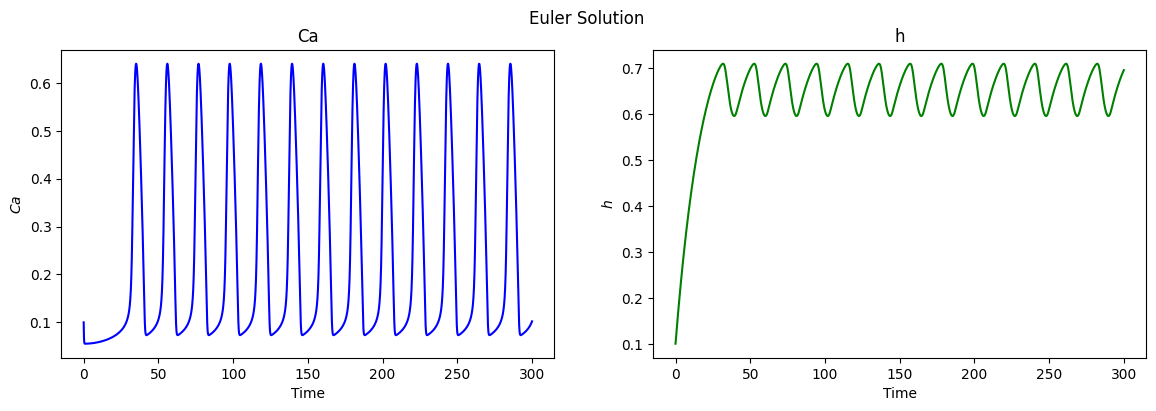

In [11]:
v2 = 0.15
a2 = 0.1
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 300, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

In [3]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1, std=1.0):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        self.std = std
        mean = 0.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, std, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features, std=std)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

In [145]:
def pinn_predictions(Ca_data, h_data, std, epoch=10001, verbose=False):

    torch.manual_seed(42)
    y0=torch.tensor([0.1, 0.1]).view(1,-1)
    pinn = PinnModel(hidden_units=30, num_features=3, std=std, y0=y0)

    Ca_euler = torch.tensor(Ca_data, dtype=torch.float32)[::100]
    h_euler = torch.tensor(h_data, dtype=torch.float32)[::100]

    time = torch.arange(0, 300, 1.0).view(-1, 1)
    t_physics = torch.linspace(0, 300, 200, requires_grad=True).view(-1, 1)

    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    IP3 = 0.5
    d5 = 0.09
    k3  = 0.08
    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)

    v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
    a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))

    lam1, lam2 = 1e-2, 1e-2
    optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
    epochs =  epoch

    v2s = []
    a2s = []

    loss_explosion = False

    for i in range(epochs):

        optimiser.zero_grad()

        pinn.train()

        # Data loss
        sol = pinn(time)
        Ca_preds = sol[:, 0].view(-1, 1)
        h_preds = sol[:, 1].view(-1, 1)
        loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
        loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

        # Physics loss
        Ca = pinn(t_physics)[:, 0].view(-1, 1)
        dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

        h = pinn(t_physics)[:, 1].view(-1, 1)
        dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

        CaER = (c0 - Ca) / c1
        ninf = Ca / (Ca + d5)
        tauh = 1 / (a2 * (Q2 + Ca))
        hinf = Q2 / (Q2 + Ca)
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh

        res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
        res2 = dh_dt - (alphah*(1-h) - betah*h)
        loss3 = torch.mean((res1)**2)
        loss4 = torch.mean((res2)**2)

        # Total loss
        loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4)

        loss.backward()
        optimiser.step()

        v2s.append(v2.item())
        a2s.append(a2.item())

        epsilon = 1e-7
        if i > 3000 and np.abs(v2s[-2] - v2s[-1]) < epsilon and np.abs(a2s[-2] - a2s[-1]) < epsilon :
            print(f"Early Stopping at epoch {i}")
            break

        if verbose == True and i % 1000 == 0:
            print(f"Epoch = {i} | Loss = {loss :.10f} | Data loss = {loss1 + loss2 :.10f} | Physics loss = {loss3 + loss4 :.10f}")

        if i > 1000 and loss > 10:
            loss_explosion = True
            print(f"Warning ! : Loss exploded at epoch {i} and Training stopped")
            break

    pred_v2 = v2s[-1]
    pred_a2 = a2s[-1]

    if loss_explosion:
        pred_v2 = np.nan
        pred_a2 = np.nan

    return pred_v2, pred_a2, loss_explosion

In [16]:
pinn_predictions(Ca_euler1, h_euler1, std=0.7, verbose=True)

Epoch = 0 | Loss = 0.0084237484 | Data loss = 0.2566335499 | Physics loss = 0.5857412815
Epoch = 1000 | Loss = 0.0001154771 | Data loss = 0.0075635277 | Physics loss = 0.0039841840
Epoch = 2000 | Loss = 0.0000206578 | Data loss = 0.0009957170 | Physics loss = 0.0010700646
Epoch = 3000 | Loss = 0.0000063061 | Data loss = 0.0002700165 | Physics loss = 0.0003605903
Epoch = 4000 | Loss = 0.0000039350 | Data loss = 0.0001540613 | Physics loss = 0.0002394406
Early Stopping at epoch 4768


(0.15381833910942078, 0.10294505208730698)

# 50 Data Testing

In [ ]:
np.random.seed(42)
num_params = 50

true_params = []
Ca_data = []
h_data  = []


for i in range(num_params):
        
    v2 = np.round(np.random.uniform(0.1, 0.2), decimals=2)
    a2 = np.round(np.random.uniform(0.1, 0.2), decimals=2)
    true_params.append([v2, a2])
    Ca, h = lirinzel_ns(v2, a2)
    Ca_data.append(Ca)
    h_data.append(h)

    # print(f"Data {i+1} has been simulated")

true_params = np.array(true_params)
Ca_data = np.array(Ca_data)
h_data  = np.array(h_data)

In [160]:
pred_params = []


for i in range(num_params):

    freq = len(find_peaks(Ca_data[i])[0])
    std = np.round(0.03 * freq + 0.35, decimals=2)

    # 14 to 16 : 0.6, 11 to 13 : 0.55 , <= 10 : 0.5
    # 17 to 19 : 0.65, 20 to 22 : 0.7, 23 to 25 : 0.8,  > 25 : 0.9
    '''if freq <= 10:
        std = 0.5
    elif 11 <= freq <= 13:
        std = 0.55
    elif 14 <= freq <= 16:
        std = 0.6
    elif 17 <= freq <= 21:
        std = 0.65
    elif 20 <= freq <= 22:
        std = 0.70
    elif 23 <= freq <= 25:
        std = 0.80
    elif freq > 25:  
        std = 0.9 '''

    # std = 0.75
    print(f"Data {i+1} | Frequency = {freq} | std = {std}")
    
    v2, a2, loss_explode = pinn_predictions(Ca_data[i], h_data[i], std, epoch=10001)
    pred_params.append([v2, a2])

    if loss_explode == False :
        print(f"Data {i+1} has been trained successfully !")
    print("----------------------------------------------------------------")
      
pred_params = np.array(pred_params)

Data 1 | Frequency = 20 | std = 0.95
Data 1 has been trained successfully !
----------------------------------------------------------------
Data 2 | Frequency = 20 | std = 0.95
Data 2 has been trained successfully !
----------------------------------------------------------------
Data 3 | Frequency = 13 | std = 0.74
Early Stopping at epoch 4087
Data 3 has been trained successfully !
----------------------------------------------------------------
Data 4 | Frequency = 17 | std = 0.86
Early Stopping at epoch 5763
Data 4 has been trained successfully !
----------------------------------------------------------------
Data 5 | Frequency = 20 | std = 0.95
Early Stopping at epoch 6289
Data 5 has been trained successfully !
----------------------------------------------------------------
Data 6 | Frequency = 17 | std = 0.86
Early Stopping at epoch 4687
Data 6 has been trained successfully !
----------------------------------------------------------------
Data 7 | Frequency = 17 | std = 0.86
D

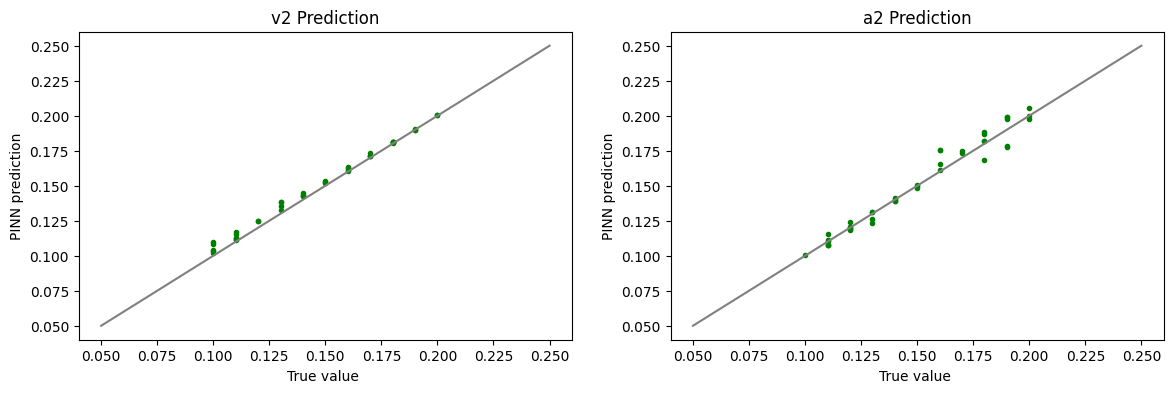

In [161]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
v2_line = np.linspace(np.min(true_params[:, 0])-0.05, np.max(true_params[:, 0])+0.05, 10)
plt.plot(true_params[:, 0], pred_params[:, 0], '.g')
plt.plot(v2_line, v2_line, c="grey")
plt.title("v2 Prediction")
plt.xlabel("True value ")
plt.ylabel("PINN prediction")

plt.subplot(122)
a2_line = np.linspace(np.min(true_params[:, 1])-0.05, np.max(true_params[:, 1])+0.05, 10)
plt.plot(true_params[:, 1], pred_params[:, 1], '.g')
plt.plot(a2_line, a2_line, c="grey")
plt.title("a2 Prediction")
plt.xlabel("True value ")
plt.ylabel("PINN prediction")

plt.show()

In [167]:
from sklearn.metrics import mean_squared_error

index = ~np.isnan(pred_params[:, 0])
v2_rmse = np.sqrt(mean_squared_error(true_params[index , 0], pred_params[index, 0]))
a2_rmse = np.sqrt(mean_squared_error(true_params[index , 1], pred_params[index, 1]))

print(f"Number of data trained = {len(pred_params[index, 0])}")
print(f"Rmse value for v2      = {v2_rmse}")
print(f"Rmse value for a2      = {a2_rmse}")

Number of data trained = 43
Rmse value for v2      = 0.0038304446497524013
Rmse value for a2      = 0.00592247365266418


In [168]:
import pandas as pd

df = pd.DataFrame({
    "True v2": true_params[:, 0],
    "Predicted v2" : pred_params[:, 0],
    "True a2": true_params[:, 1],
    "Predicted a2" : pred_params[:, 1],
})

df

,True v2,Predicted v2,True a2,Predicted a2
0,0.14,0.143317,0.20,0.205859
1,0.17,0.171263,0.16,0.175516
2,0.12,0.125004,0.12,0.118984
3,0.11,0.112819,0.19,0.199231
4,0.16,0.161441,0.17,0.173202
5,0.10,0.103995,0.20,0.199970
6,0.18,0.181211,0.12,0.120753
7,0.12,0.125004,0.12,0.118984
8,0.13,NaN,0.15,NaN
9,0.14,0.142504,0.13,0.131127


# 100 Data Testing

In [169]:
np.random.seed(42)
num_params = 100

true_params = []
Ca_data = []
h_data  = []


for i in range(num_params):
        
    v2 = np.round(np.random.uniform(0.1, 0.2), decimals=3)
    a2 = np.round(np.random.uniform(0.1, 0.2), decimals=3)
    true_params.append([v2, a2])
    Ca, h = lirinzel_ns(v2, a2)
    Ca_data.append(Ca)
    h_data.append(h)

    # print(f"Data {i+1} has been simulated")

true_params = np.array(true_params)
Ca_data = np.array(Ca_data)
h_data  = np.array(h_data)

In [171]:
pred_params = []


for i in range(num_params):

    freq = len(find_peaks(Ca_data[i])[0])
    std = np.round(0.03 * freq + 0.35, decimals=2)

    # 14 to 16 : 0.6, 11 to 13 : 0.55 , <= 10 : 0.5
    # 17 to 19 : 0.65, 20 to 22 : 0.7, 23 to 25 : 0.8,  > 25 : 0.9
    '''if freq <= 10:
        std = 0.5
    elif 11 <= freq <= 13:
        std = 0.55
    elif 14 <= freq <= 16:
        std = 0.6
    elif 17 <= freq <= 21:
        std = 0.65
    elif 20 <= freq <= 22:
        std = 0.70
    elif 23 <= freq <= 25:
        std = 0.80
    elif freq > 25:  
        std = 0.9 '''

    # std = 0.75
    print(f"Data {i+1} | Frequency = {freq} | std = {std}")
    
    v2, a2, loss_explode = pinn_predictions(Ca_data[i], h_data[i], std, epoch=10001)
    pred_params.append([v2, a2])

    if loss_explode == False :
        print(f"Data {i+1} has been trained successfully !")
    print("----------------------------------------------------------------")
      
pred_params = np.array(pred_params)

Data 1 | Frequency = 20 | std = 0.95
Data 1 has been trained successfully !
----------------------------------------------------------------
Data 2 | Frequency = 20 | std = 0.95
Early Stopping at epoch 4323
Data 2 has been trained successfully !
----------------------------------------------------------------
Data 3 | Frequency = 12 | std = 0.71
Early Stopping at epoch 3402
Data 3 has been trained successfully !
----------------------------------------------------------------
Data 4 | Frequency = 17 | std = 0.86
Warning ! : Loss exploded at epoch 2714 and Training stopped
----------------------------------------------------------------
Data 5 | Frequency = 20 | std = 0.95
Early Stopping at epoch 8041
Data 5 has been trained successfully !
----------------------------------------------------------------
Data 6 | Frequency = 17 | std = 0.86
Data 6 has been trained successfully !
----------------------------------------------------------------
Data 7 | Frequency = 17 | std = 0.86
Data 7 h

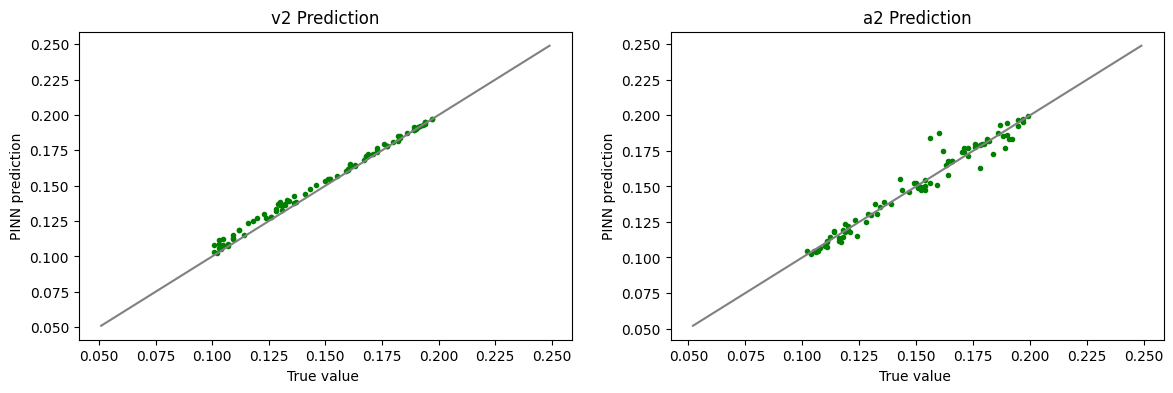

In [172]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
v2_line = np.linspace(np.min(true_params[:, 0])-0.05, np.max(true_params[:, 0])+0.05, 10)
plt.plot(true_params[:, 0], pred_params[:, 0], '.g')
plt.plot(v2_line, v2_line, c="grey")
plt.title("v2 Prediction")
plt.xlabel("True value ")
plt.ylabel("PINN prediction")

plt.subplot(122)
a2_line = np.linspace(np.min(true_params[:, 1])-0.05, np.max(true_params[:, 1])+0.05, 10)
plt.plot(true_params[:, 1], pred_params[:, 1], '.g')
plt.plot(a2_line, a2_line, c="grey")
plt.title("a2 Prediction")
plt.xlabel("True value ")
plt.ylabel("PINN prediction")

plt.show()

In [173]:
from sklearn.metrics import mean_squared_error

index = ~np.isnan(pred_params[:, 0])
v2_rmse = np.sqrt(mean_squared_error(true_params[index , 0], pred_params[index, 0]))
a2_rmse = np.sqrt(mean_squared_error(true_params[index , 1], pred_params[index, 1]))

print(f"Number of data trained = {len(pred_params[index, 0])}")
print(f"Rmse value for v2      = {v2_rmse}")
print(f"Rmse value for a2      = {a2_rmse}")

Number of data trained = 84
Rmse value for v2      = 0.003915929594859185
Rmse value for a2      = 0.0062566304575986794


In [174]:
import pandas as pd

df = pd.DataFrame({
    "True v2": true_params[:, 0],
    "Predicted v2" : pred_params[:, 0],
    "True a2": true_params[:, 1],
    "Predicted a2" : pred_params[:, 1],
})

df

,True v2,Predicted v2,True a2,Predicted a2
0,0.137,0.138368,0.195,0.192666
1,0.173,0.176995,0.160,0.187459
2,0.116,0.123486,0.116,0.111260
3,0.106,NaN,0.187,NaN
4,0.160,0.161482,0.171,0.174260
...,...,...,...,...
95,0.109,0.112194,0.190,0.194848
96,0.190,0.190418,0.163,0.164982
97,0.134,NaN,0.135,NaN
98,0.173,0.173739,0.190,0.185900


# Stochastic Data

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

In [2]:
def model_stochastic(t, x, P, dt):
    IP3, v1, v2, v3, a2, d1, d2, d3, d5, k3 = P
    c0 = 2
    c1 = 0.185

    Ca, h = x
    CaER = (c0 - Ca) / c1
    pinf = IP3 / (IP3 + d1)
    ninf = Ca / (Ca + d5)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)

    alphah = hinf / tauh
    betah = (1 - hinf) / tauh
    dh = alphah * (1 - h) - betah * h
    dCa = c1 * v1 * pinf**3 * ninf**3 * h**3 * (CaER - Ca) + c1 * v2 * (CaER - Ca) - v3 * Ca**2 / (Ca**2 + k3**2)

    # Stochastic noise
    Nd = 2
    gamma1, gamma2 = np.random.rand(2)
    gh = np.sqrt(-2 * (alphah * (1 - h) + betah * h) * np.log(gamma1) / Nd) * np.sin(2 * np.pi * gamma2)
    dh += gh * np.sqrt(dt)

    return np.array([dCa, dh])

In [42]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1, std=1.0):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        self.std = std
        mean = 0.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, std, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features, std=std)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

In [43]:
def pinn_predictions(Ca_data, h_data, std, epoch=10001, verbose=False):

    torch.manual_seed(42)
    y0=torch.tensor([0.1, 0.1]).view(1,-1)
    pinn = PinnModel(hidden_units=30, num_features=3, std=std, y0=y0)

    Ca_euler = torch.tensor(Ca_data, dtype=torch.float32)[::10]
    h_euler = torch.tensor(h_data, dtype=torch.float32)[::10]

    time = torch.arange(0, 200, 1.0).view(-1, 1)
    t_physics = torch.linspace(0, 200, 200, requires_grad=True).view(-1, 1)

    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    IP3 = 0.5
    d5 = 0.0823
    k3  = 0.1
    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)

    v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
    a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))

    lam1, lam2 = 1e-2, 1e-2
    optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
    epochs =  epoch

    v2s = []
    a2s = []

    loss_explosion = False

    for i in range(epochs):

        optimiser.zero_grad()

        pinn.train()

        # Data loss
        sol = pinn(time)
        Ca_preds = sol[:, 0].view(-1, 1)
        h_preds = sol[:, 1].view(-1, 1)
        loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
        loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

        # Physics loss
        Ca = pinn(t_physics)[:, 0].view(-1, 1)
        dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

        h = pinn(t_physics)[:, 1].view(-1, 1)
        dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

        CaER = (c0 - Ca) / c1
        ninf = Ca / (Ca + d5)
        tauh = 1 / (a2 * (Q2 + Ca))
        hinf = Q2 / (Q2 + Ca)
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh

        res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
        res2 = dh_dt - (alphah*(1-h) - betah*h)
        loss3 = torch.mean((res1)**2)
        loss4 = torch.mean((res2)**2)

        # Total loss
        loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4)

        loss.backward()
        optimiser.step()

        v2s.append(v2.item())
        a2s.append(a2.item())

        epsilon = 1e-7
        if i > 3000 and np.abs(v2s[-2] - v2s[-1]) < epsilon and np.abs(a2s[-2] - a2s[-1]) < epsilon :
            print(f"Early Stopping at epoch {i}")
            break

        if verbose == True and i % 1000 == 0:
            print(f"Epoch = {i} | Loss = {loss :.10f} | Data loss = {loss1 + loss2 :.10f} | Physics loss = {loss3 + loss4 :.10f}")

        if i > 1000 and loss > 10:
            loss_explosion = True
            print(f"Warning ! : Loss exploded at epoch {i} and Training stopped")
            break

    pred_v2 = v2s[-1]
    pred_a2 = a2s[-1]

    if loss_explosion:
        pred_v2 = np.nan
        pred_a2 = np.nan

    return pred_v2, pred_a2, loss_explosion

In [44]:
num_data = 3

P = [0.5, 6, 0.11, 0.9, 0.2, 0.13, 1.049, 0.9434, 0.0823, 0.1]
dt = 0.1
t_end = 200
t = np.arange(0, t_end, dt)
num_steps = len(t)
y02 = np.array([0.1, 0.1])
y = np.zeros((2, num_steps))
y[:, 0] = y02

true_v2 = P[2]
true_a2 = P[4]

Ca_stoch_data = []
h_stoch_data = []

for i in range(num_data):
    np.random.seed(10*i)
    y = np.zeros((2, num_steps))
    for n in range(num_steps - 1):
        f = model_stochastic(t[n], y[:, n], P, dt)
        y[:, n + 1] = y[:, n] + dt * f
    Ca_stoch, h_stoch = y

    Ca_stoch_data.append(Ca_stoch)
    h_stoch_data.append(h_stoch)

    print(f"Stochastic data  {i+1} Simulated !")

Ca_stoch_data = np.array(Ca_stoch_data)
h_stoch_data = np.array(h_stoch_data)

Stochastic data  1 Simulated !
Stochastic data  2 Simulated !
Stochastic data  3 Simulated !


In [45]:
pred_params = []


for i in range(num_data):

    std = 1.0
    print(f"Data {i+1} | std = {std}")
    
    v2, a2, loss_explode = pinn_predictions(Ca_stoch_data[i], h_stoch_data[i], std, epoch=10001, verbose=True)
    pred_params.append([v2, a2])

    if loss_explode == False :
        print(f"Data {i+1} has been trained successfully !")
    print("----------------------------------------------------------------")
      
pred_params = np.array(pred_params)

Data 1 | std = 1.0
Epoch = 0 | Loss = 0.0089606326 | Data loss = 0.2350348681 | Physics loss = 0.6610284448
Epoch = 1000 | Loss = 0.0001772315 | Data loss = 0.0142418370 | Physics loss = 0.0034813150
Epoch = 2000 | Loss = 0.0000310995 | Data loss = 0.0021942395 | Physics loss = 0.0009157125
Epoch = 3000 | Loss = 0.0000135784 | Data loss = 0.0008397881 | Physics loss = 0.0005180513
Early Stopping at epoch 3398
Data 1 has been trained successfully !
----------------------------------------------------------------
Data 2 | std = 1.0
Epoch = 0 | Loss = 0.0089248400 | Data loss = 0.2314556241 | Physics loss = 0.6610284448
Epoch = 1000 | Loss = 0.0001979871 | Data loss = 0.0146175735 | Physics loss = 0.0051811375
Epoch = 2000 | Loss = 0.0000341787 | Data loss = 0.0023409680 | Physics loss = 0.0010769047
Epoch = 3000 | Loss = 0.0000176046 | Data loss = 0.0011658759 | Physics loss = 0.0005945882
Epoch = 4000 | Loss = 0.0000101744 | Data loss = 0.0006650548 | Physics loss = 0.0003523900
Epoch =

In [47]:
pred_params

array([[0.11256462, 0.15577134],
       [0.11085329, 0.17257707],
       [0.11214233, 0.1440423 ]])

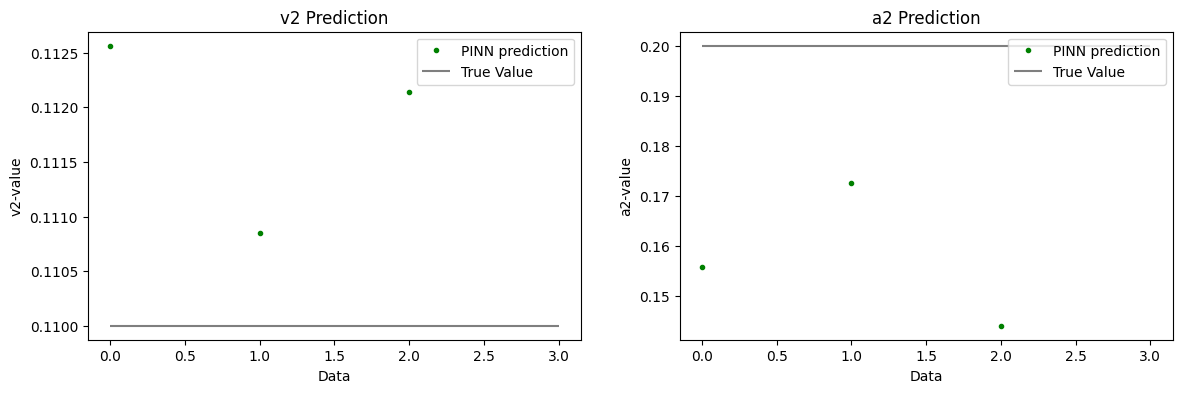

In [48]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.plot(pred_params[:, 0], '.g', label="PINN prediction")
plt.hlines(true_v2, 0, len(pred_params[:, 0]), color="tab:grey", label="True Value")
plt.title("v2 Prediction")
plt.xlabel("Data")
plt.ylabel("v2-value")
plt.legend()

plt.subplot(122)
plt.plot(pred_params[:, 1], '.g', label="PINN prediction")
plt.hlines(true_a2, 0, len(pred_params[:, 1]), color="tab:grey", label="True Value")
plt.title("a2 Prediction")
plt.xlabel("Data")
plt.ylabel("a2-value")
plt.legend()

plt.show()